In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

img_dir = 'train'
mask_dir = 'train/masks'
excel_file = 'train/classif.xlsx'
data_feature_file = 'data_features.csv'
data_all_feature_file = 'data_all_features.csv'

# Load classification file
def load_classification(excel_file):
    if os.path.exists(excel_file):
        return pd.read_excel(excel_file)
    else:
        print(f"Excel file {excel_file} not found.")
        return None

# Load features
def load_features(data_feature_file):
    if os.path.exists(data_feature_file):
        return pd.read_csv(data_feature_file)
    else:
        print(f"Feature file {data_feature_file} not found.")
        return None

classif_df = load_classification(excel_file)
filtered_indices = classif_df[classif_df['bug_type'].str.contains('&')].index
classif_df = classif_df[~classif_df['bug_type'].str.contains('&')]

features_df = load_features(data_feature_file)
features_df = features_df.drop(filtered_indices[0], axis=0)

all_features_df = load_features(data_all_feature_file)
all_features_df = all_features_df.drop(filtered_indices[0], axis=0)

# 处理标签
def process_labels(df):
    bug_types = []
    species = []
    
    for _, row in df.iterrows():
        bugs = row['bug_type']
        species_info = row['species']
        
        # 处理x2
        if ' x2' in species_info:
            bugs = [bugs.replace(' x2','')] * 2
            species_info = [species_info.replace(' x2','')] * 2
        else:
            bugs = bugs.split(' & ')
            species_info = species_info.split(' & ')
        
        # 处理问号
        bugs = [bug.replace(' ?', '') for bug in bugs]
        species_info = [specie.replace(' ?', '') for specie in species_info]
        
        bug_types.append(bugs)
        species.append(species_info)
    
    df['bug_type'] = bug_types
    df['species'] = species
    return df

classif_df = process_labels(classif_df)
print(classif_df.head())

# 使用MultiLabelBinarizer转换标签
mlb_bug_type = MultiLabelBinarizer()
mlb_species = MultiLabelBinarizer()

bug_type_encoded = mlb_bug_type.fit_transform(classif_df['bug_type'])
species_encoded = mlb_species.fit_transform(classif_df['species'])

# 转换为DataFrame
bug_type_df = pd.DataFrame(bug_type_encoded, columns=mlb_bug_type.classes_)
species_df = pd.DataFrame(species_encoded, columns=mlb_species.classes_)

# 合并所有数据
all_data_df = pd.concat([classif_df.drop(columns=['bug_type', 'species']), bug_type_df, species_df, features_df], axis=1)


   ID bug_type           species
0   1    [Bee]  [Apis mellifera]
1   2    [Bee]  [Apis mellifera]
2   3    [Bee]  [Apis mellifera]
3   4    [Bee]  [Apis mellifera]
4   5    [Bee]  [Apis mellifera]


In [22]:
corr_matrix = all_features_df.corr()
corr_matrix

,SymmetryIndex,LongestOrthogonalRatio,ratio,min_red,min_green,min_blue,max_red,max_green,max_blue,mean_red,...,median_red,median_green,median_blue,std_red,std_green,std_blue,contrast,homogeneity,energy,correlation
SymmetryIndex,1.000000,-0.153074,0.845042,0.512529,0.160282,0.317755,0.276844,0.180870,0.220426,0.261359,...,0.213051,0.442575,0.173034,-0.494173,-0.491751,-0.265213,0.060678,-0.100775,-0.092344,-0.120329
LongestOrthogonalRatio,-0.153074,1.000000,-0.174292,-0.141564,-0.067683,-0.068732,-0.064789,-0.058284,-0.023830,-0.060289,...,-0.055923,-0.072636,0.054755,0.056850,0.052286,0.047678,0.019524,-0.044766,0.031716,-0.027444
ratio,0.845042,-0.174292,1.000000,0.606117,0.193497,0.385118,0.240720,0.165364,0.244905,0.360807,...,0.315361,0.605731,0.301305,-0.623736,-0.594466,-0.323828,0.053995,-0.134559,-0.121165,-0.137772
min_red,0.512529,-0.141564,0.606117,1.000000,0.477152,0.673282,0.142419,0.024031,0.105394,0.427155,...,0.372530,0.497269,0.237750,-0.525054,-0.548212,-0.372905,0.072871,-0.294823,-0.195521,-0.261117
min_green,0.160282,-0.067683,0.193497,0.477152,1.000000,0.423707,0.006670,0.044841,-0.018967,0.137047,...,0.113046,0.230039,0.033011,-0.170285,-0.147705,-0.112492,-0.097544,-0.110431,-0.143906,0.103085
min_blue,0.317755,-0.068732,0.385118,0.673282,0.423707,1.000000,0.114021,-0.009164,0.106811,0.251993,...,0.220986,0.340598,0.251957,-0.328982,-0.374313,-0.170232,-0.005660,-0.184872,-0.121171,-0.158889
max_red,0.276844,-0.064789,0.240720,0.142419,0.006670,0.114021,1.000000,0.876585,0.787561,0.321296,...,0.269862,0.330513,0.232659,0.068769,0.087956,0.125879,0.235291,0.045739,0.044163,-0.186862
max_green,0.180870,-0.058284,0.165364,0.024031,0.044841,-0.009164,0.876585,1.000000,0.791046,0.258429,...,0.208463,0.319596,0.192957,0.133307,0.221483,0.192057,0.225520,0.156065,0.046767,-0.060021
max_blue,0.220426,-0.023830,0.244905,0.105394,-0.018967,0.106811,0.787561,0.791046,1.000000,0.248275,...,0.196846,0.328462,0.280003,0.023036,0.100989,0.213693,0.248914,-0.014695,-0.012338,-0.203575
mean_red,0.261359,-0.060289,0.360807,0.427155,0.137047,0.251993,0.321296,0.258429,0.248275,1.000000,...,0.975636,0.854319,0.728158,-0.180553,-0.039939,0.041560,0.158290,-0.024376,-0.057602,-0.167283


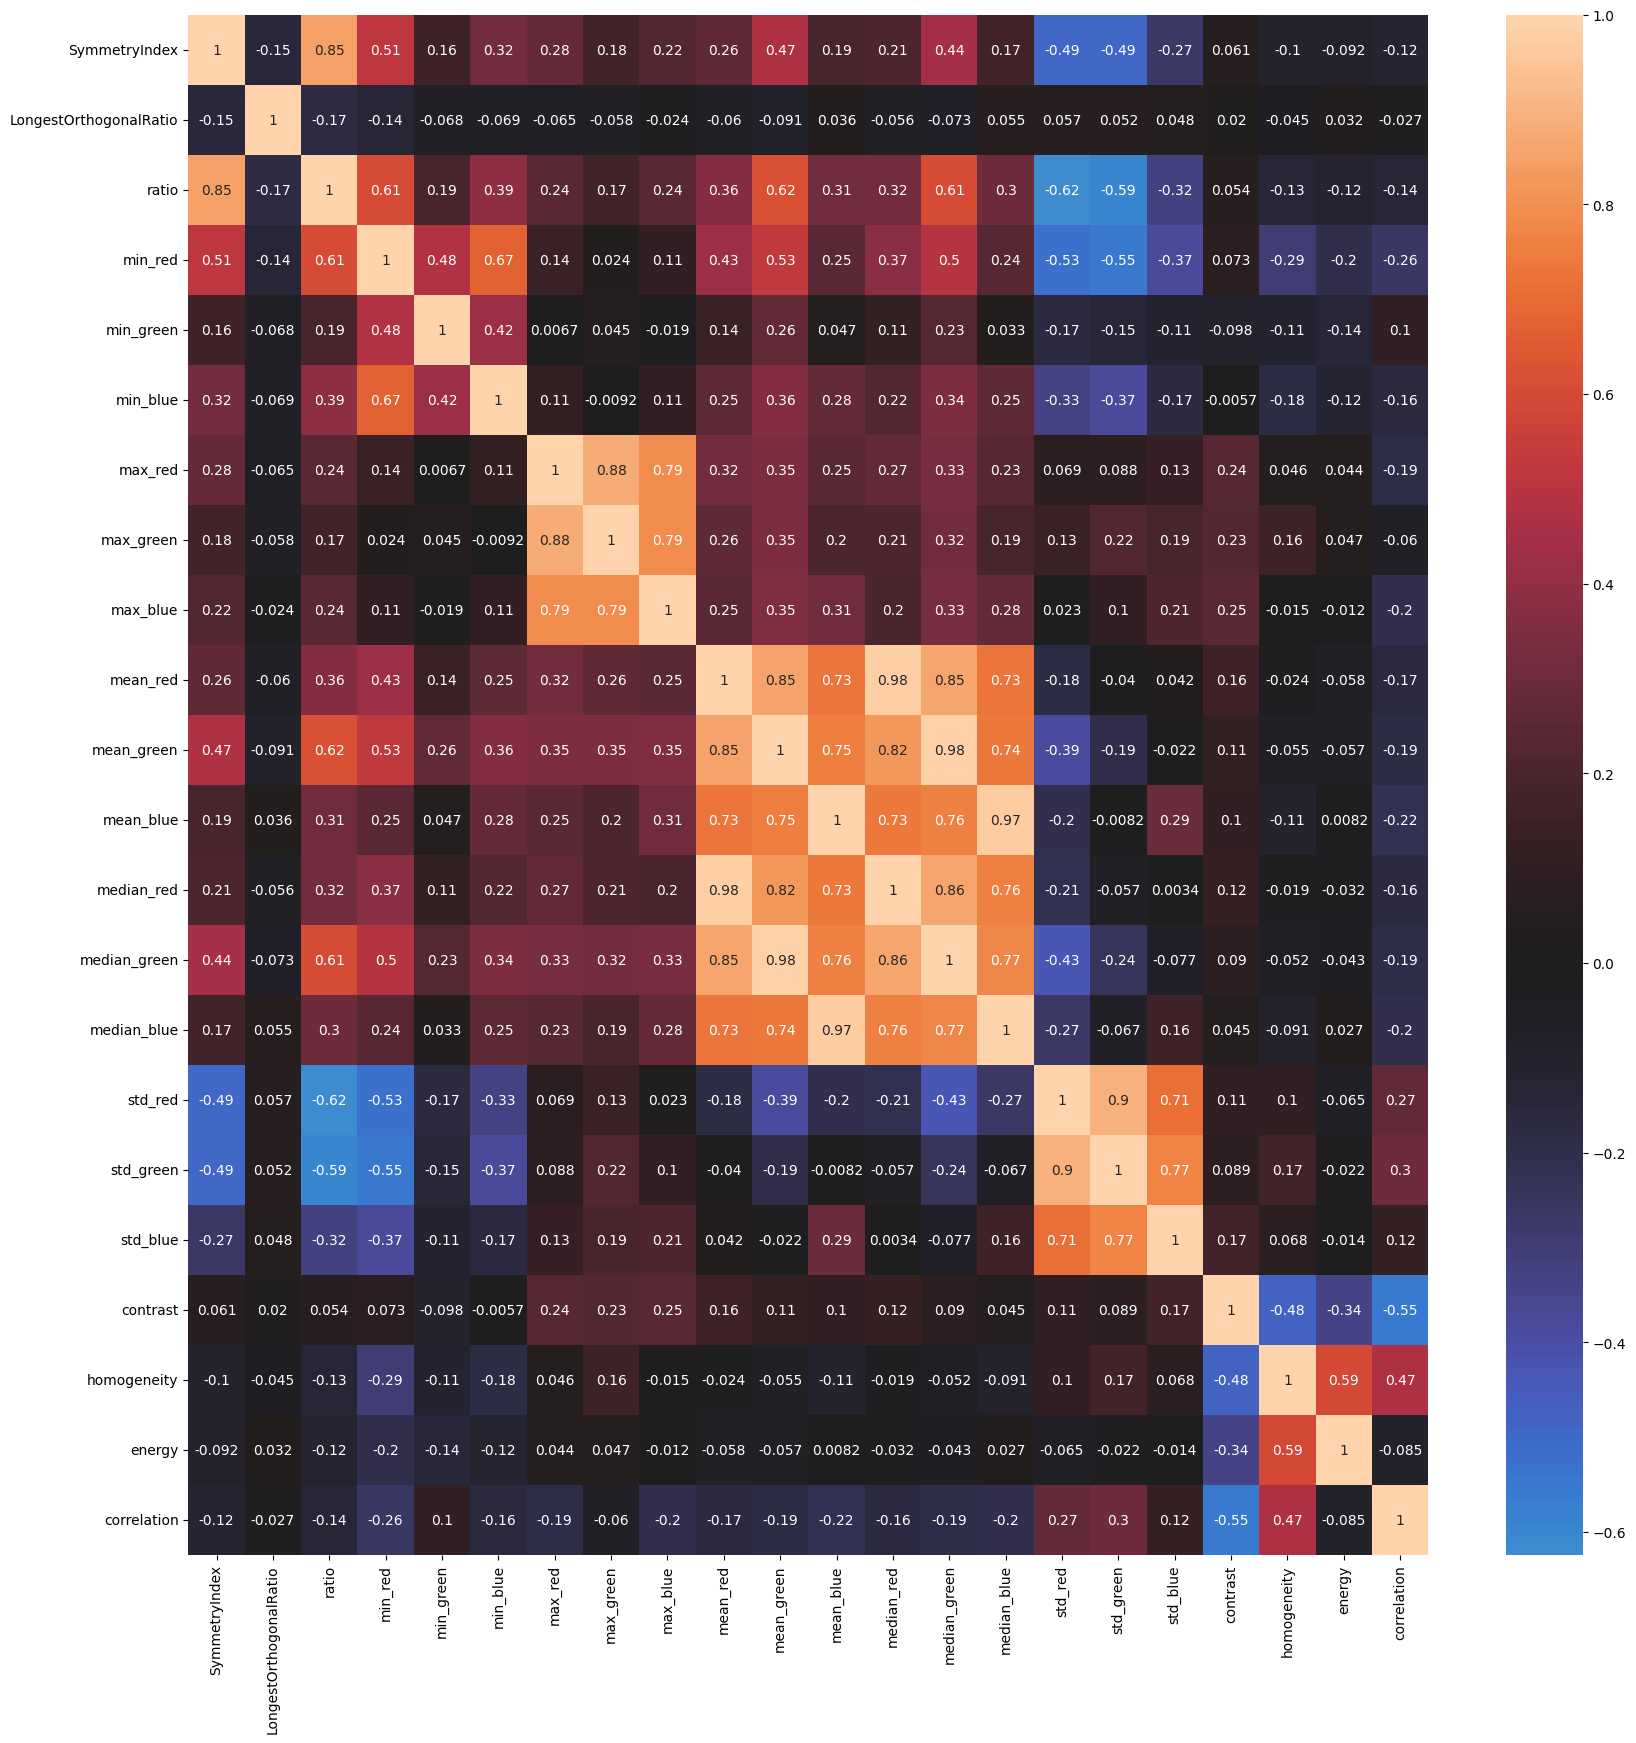

In [23]:
fig,axes = plt.subplots(figsize=(20,20))
sns.heatmap(corr_matrix,annot=True,center=0)
plt.show()

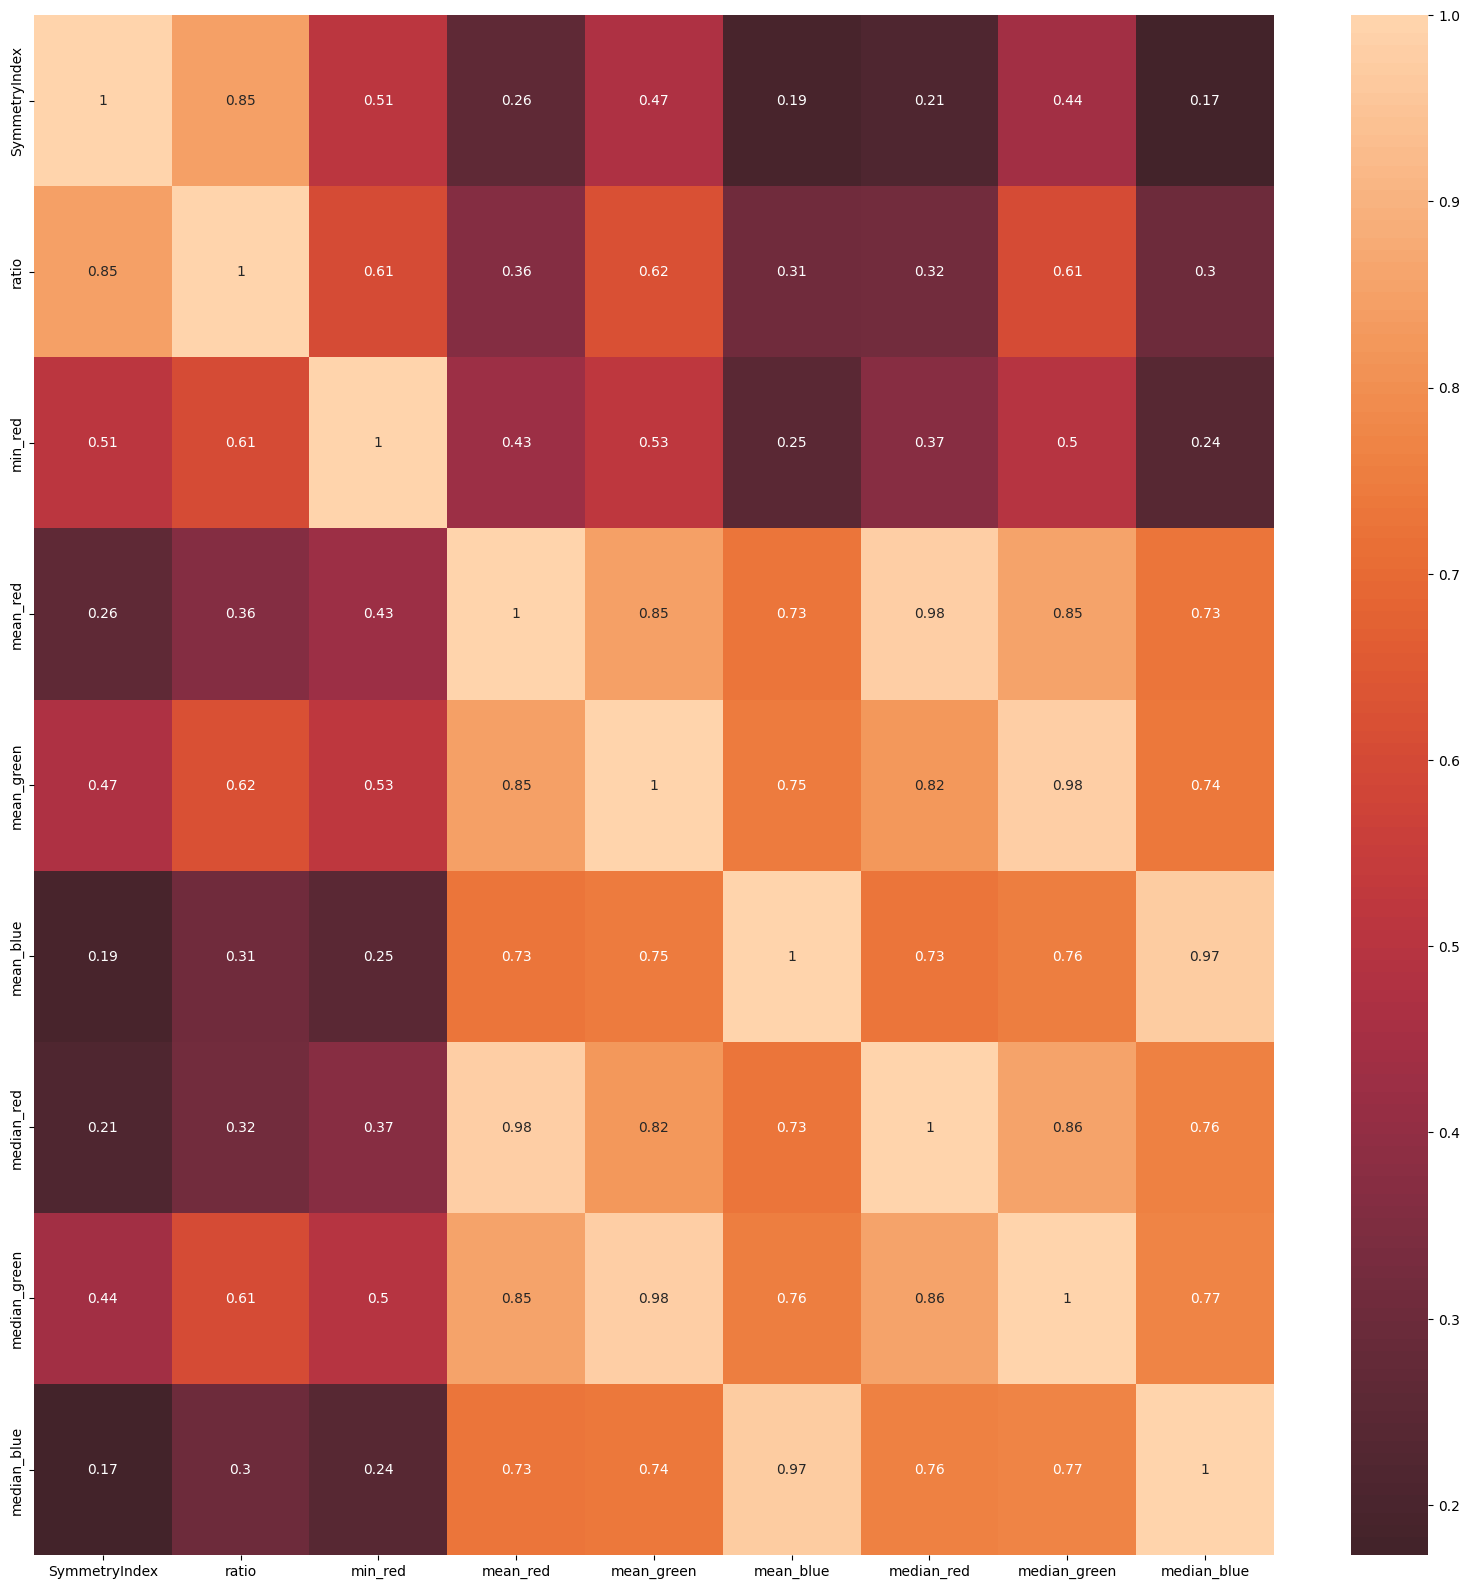

In [24]:
corr_matrix2 = features_df.corr()

fig,axes = plt.subplots(figsize=(20,20))
sns.heatmap(corr_matrix2,annot=True,center=0)
plt.show()

C:\Users\romai\AppData\Local\Temp\ipykernel_9396\318696258.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values,  palette="viridis")


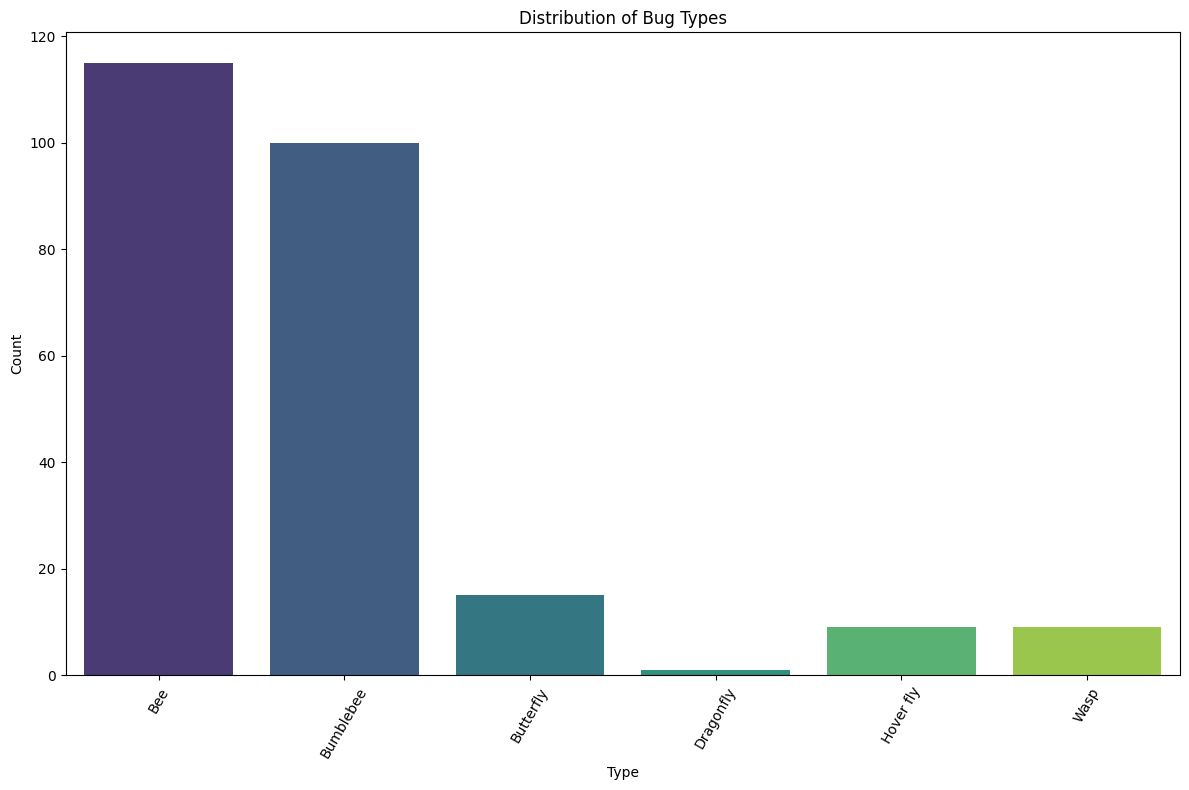

C:\Users\romai\AppData\Local\Temp\ipykernel_9396\318696258.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values,  palette="viridis")


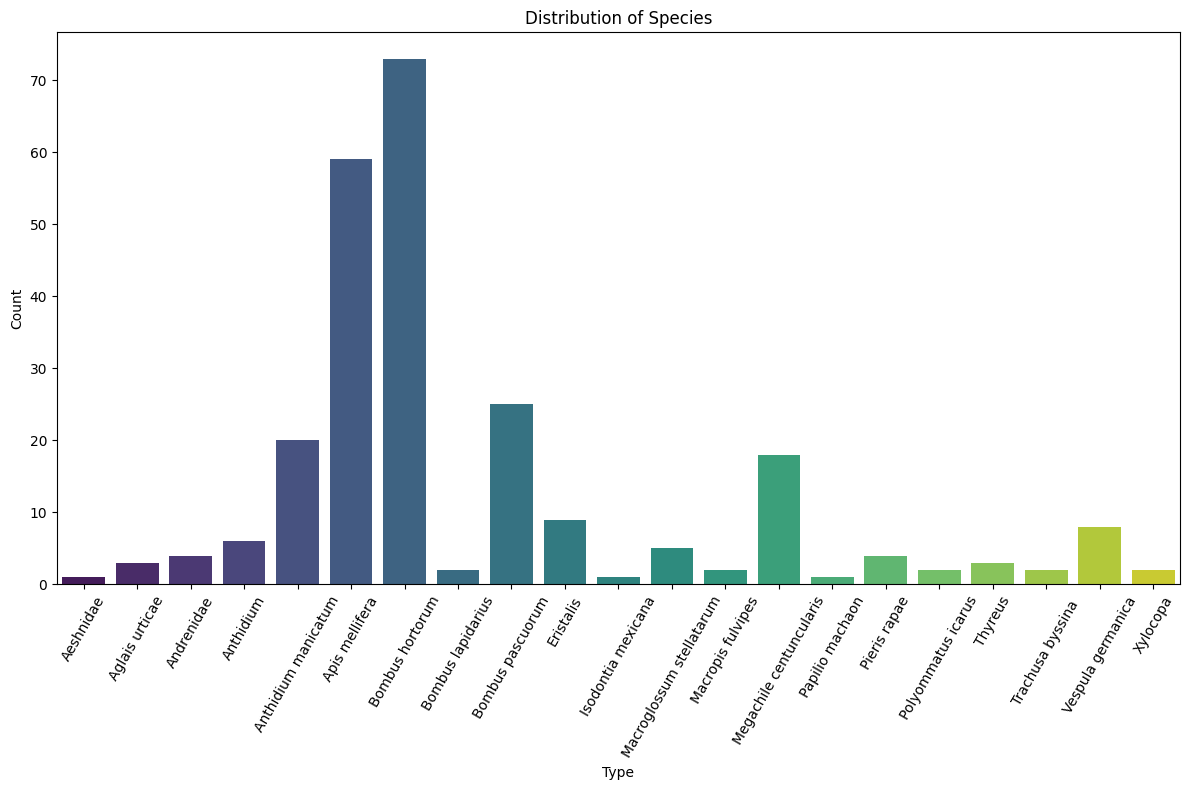

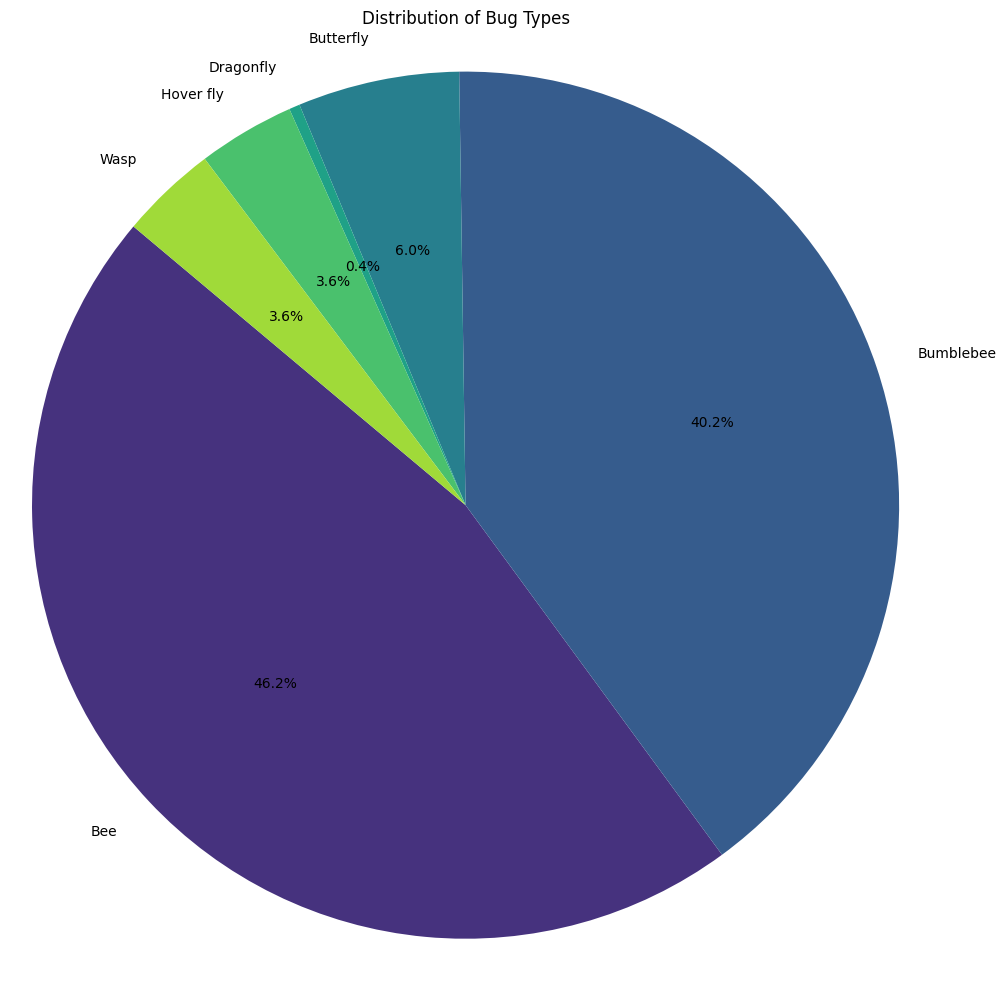

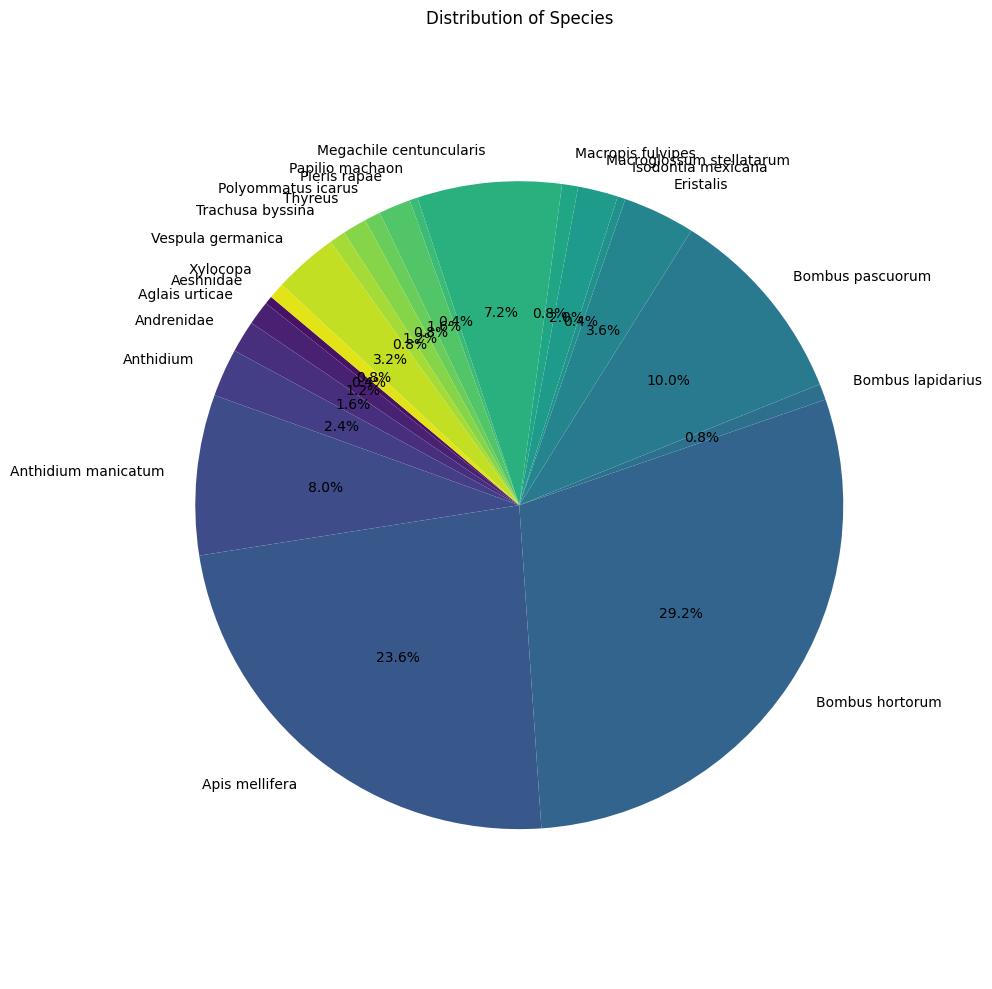

In [25]:
# 可视化分布
def plot_distribution(data, title):
    counts = data.sum()
    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts.index, y=counts.values,  palette="viridis")
    plt.title(title)
    plt.xlabel('Type')
    plt.ylabel('Count')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_distribution(bug_type_df, 'Distribution of Bug Types')
plot_distribution(species_df, 'Distribution of Species')

# 昆虫类型分布的饼图
def plot_pie_distribution(data, title):
    counts = data.sum()
    colors = sns.color_palette('viridis', len(counts))
    plt.figure(figsize=(10, 10))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140,colors=colors)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout() 
    plt.show()

plot_pie_distribution(bug_type_df, 'Distribution of Bug Types')
plot_pie_distribution(species_df, 'Distribution of Species')


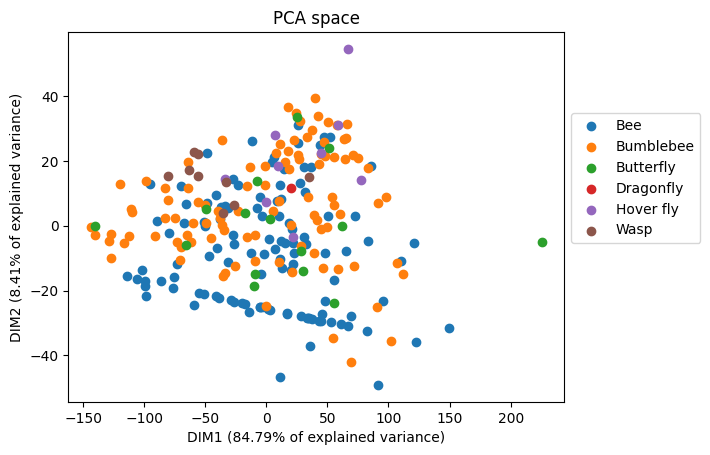

In [26]:
classif_df_string = load_classification(excel_file)
classif_df_string = classif_df_string[~classif_df_string['bug_type'].str.contains('&')]

features = features_df

digit_class=classif_df_string["bug_type"]
dig_list=np.unique(digit_class.values)
pca = PCA(n_components=2)
digits_pca = pca.fit_transform(features)

pc1 = round(pca.explained_variance_ratio_[0] * 100,2)
pc2 = round(pca.explained_variance_ratio_[1] * 100,2)

fig, ax = plt.subplots();
for dig in dig_list:
    ax.scatter(digits_pca[digit_class==dig, 0], digits_pca[digit_class==dig, 1],label=dig);
ax.set_xlabel("DIM1 ({0}% of explained variance)".format(pc1, fontsize=11))
ax.set_ylabel("DIM2 ({0}% of explained variance)".format(pc2, fontsize=11))
ax.legend(bbox_to_anchor=(1, 0.8));    
ax.set_title('PCA space', fontsize=12);


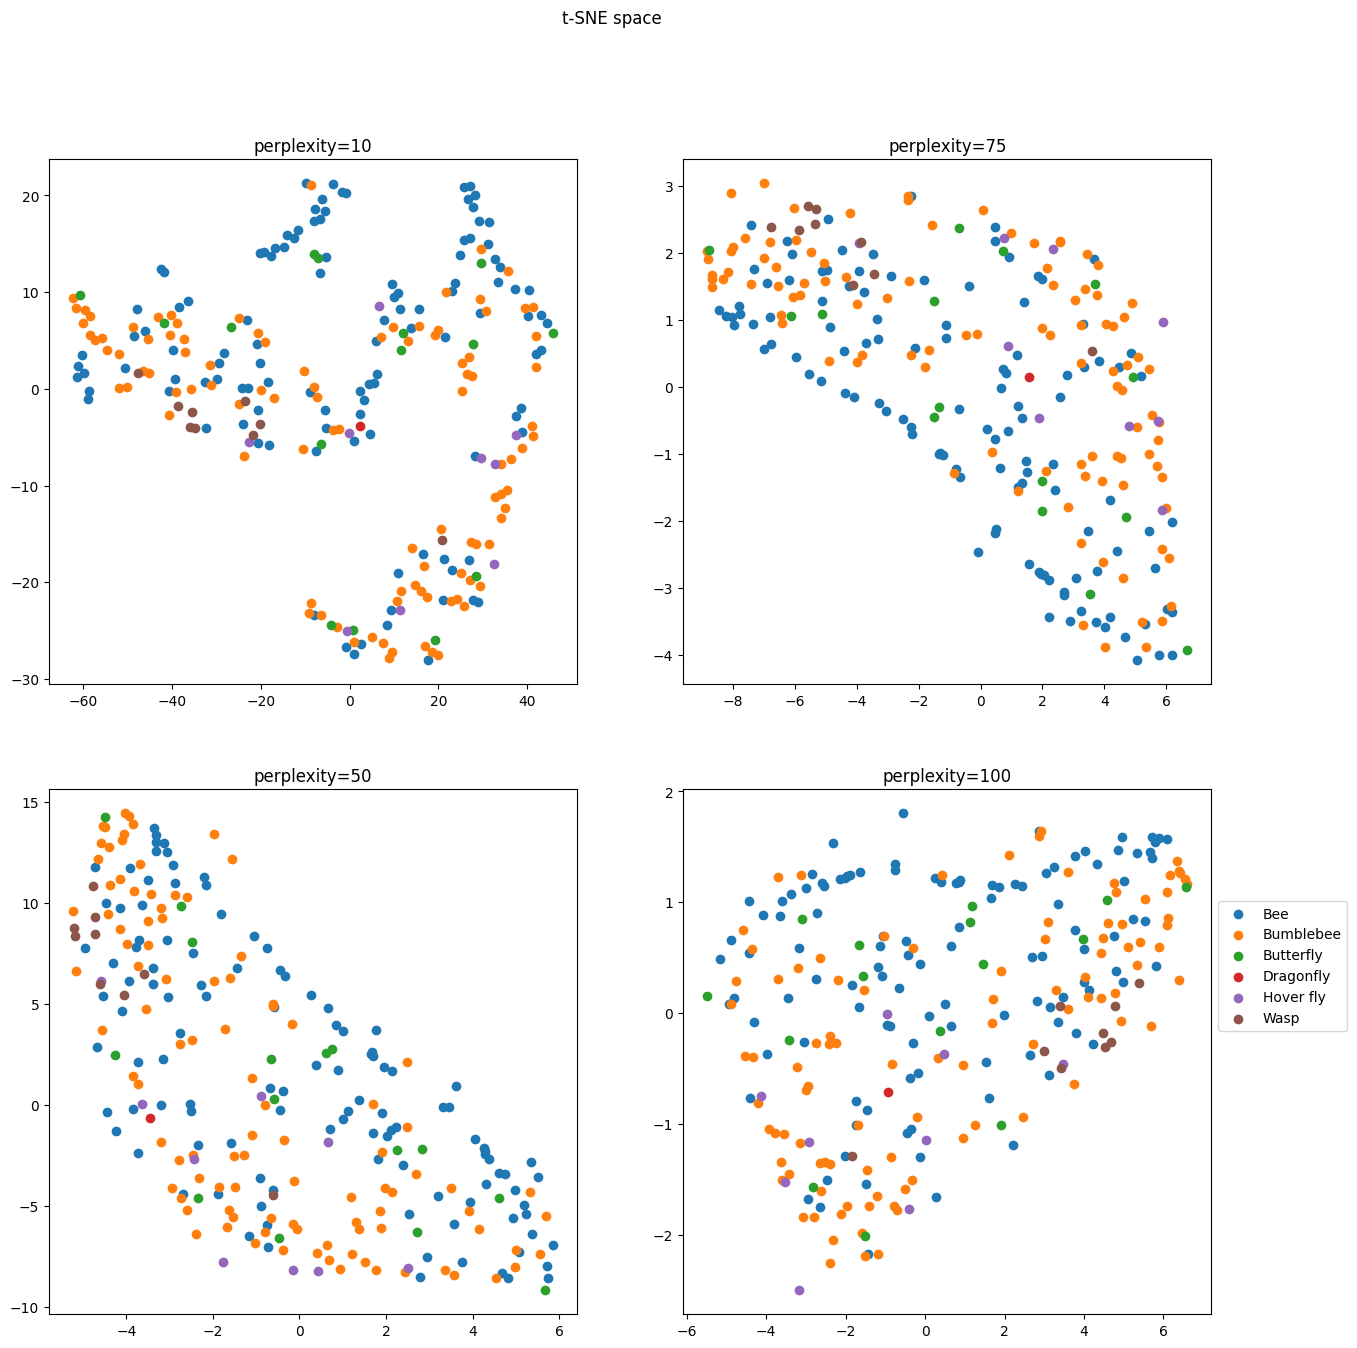

In [27]:
#TSNE
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE

nb_lines = 2
nb_cols = 2

fig, ax = plt.subplots(nb_lines, nb_cols, figsize=(15, 15))
line_ids, col_ids = np.meshgrid(range(0, nb_lines), 
                                range(0, nb_cols))
fig.suptitle('t-SNE space', fontsize=12)
for perp, line_id, col_id in zip([10,50,75,100],
                                      line_ids.flatten(), col_ids.flatten()):
   model = TSNE(n_components=2,perplexity=perp, random_state=0)
   digits_tsne = model.fit_transform(features)
   for dig in dig_list:
         ax[line_id, col_id].scatter(digits_tsne[digit_class==dig, 0], digits_tsne[digit_class==dig, 1],label=dig);    
   
   ax[line_id, col_id].set_title("perplexity={0}".format(perp))
plt.legend(bbox_to_anchor=(1, 0.8));  

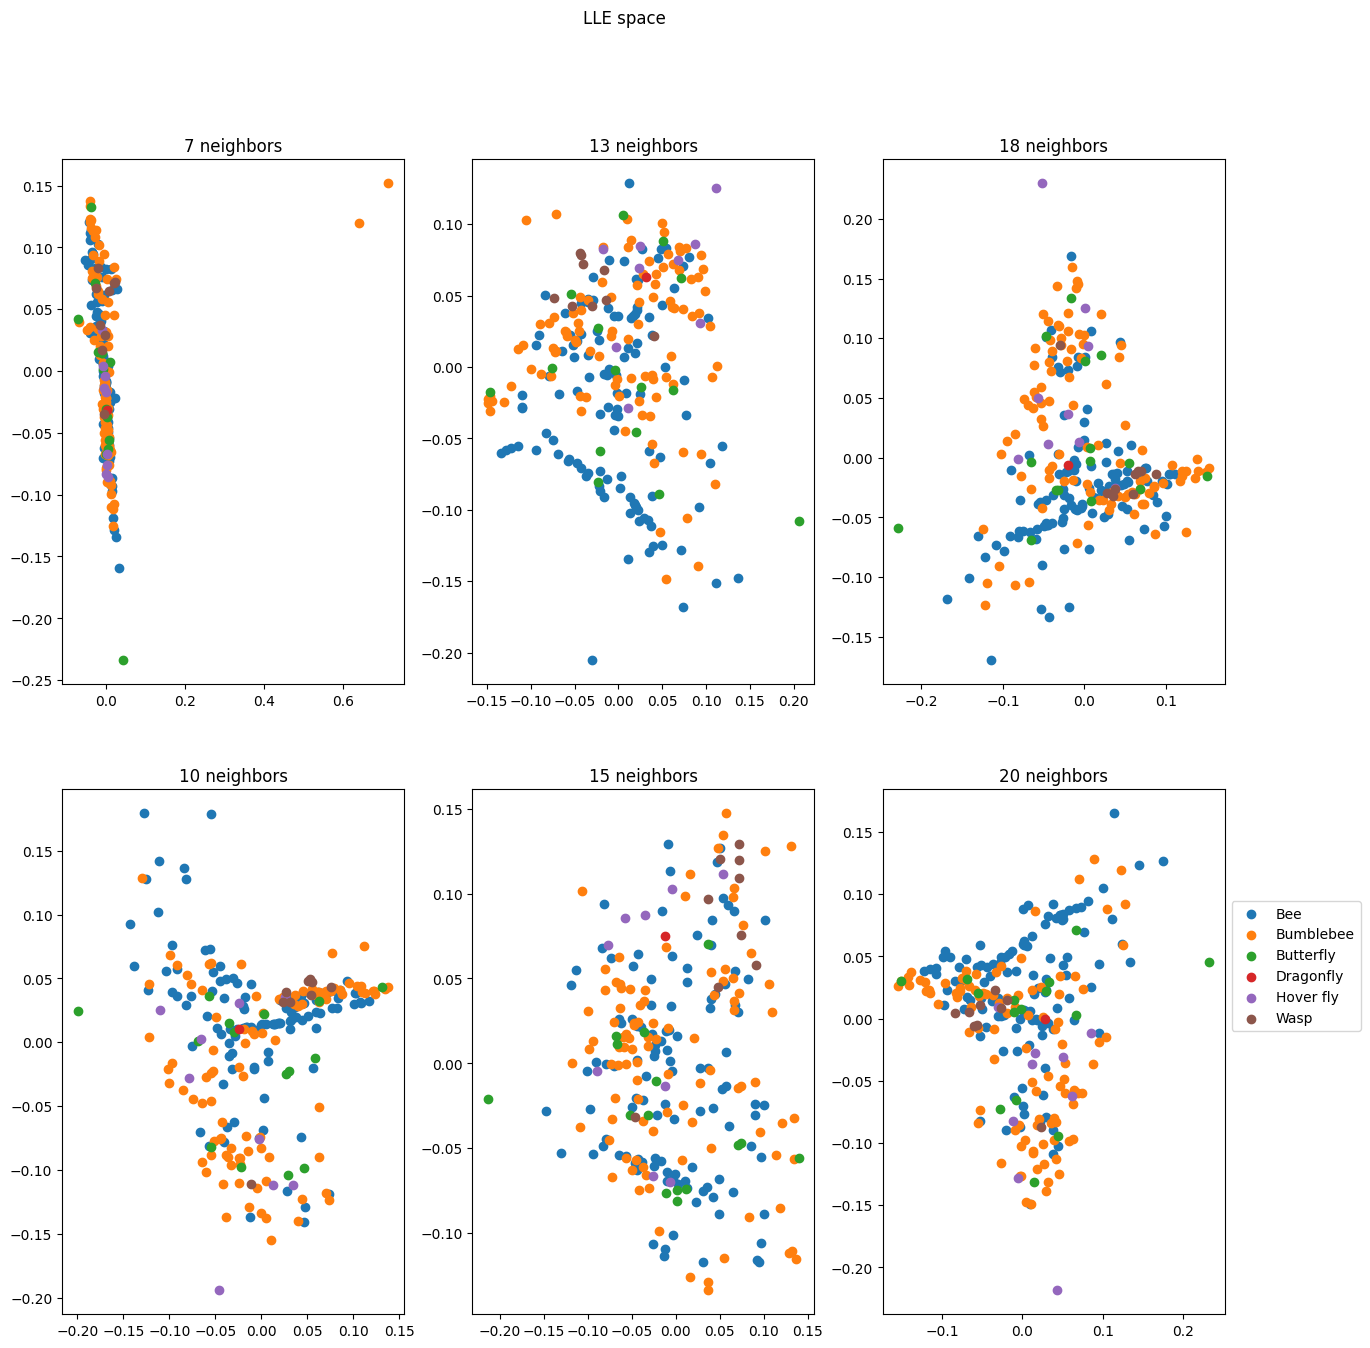

In [28]:
nb_lines = 2
nb_cols = 3

fig, ax = plt.subplots(nb_lines, nb_cols, figsize=(15, 15))
line_ids, col_ids = np.meshgrid(range(0, nb_lines), 
                                range(0, nb_cols))
fig.suptitle('LLE space', fontsize=12)
for n_neighbor, line_id, col_id in zip([7, 10, 13, 15, 18, 20],
                                      line_ids.flatten(), col_ids.flatten()):
   model = LocallyLinearEmbedding(n_neighbors=n_neighbor, random_state=0)
   digits_lle = model.fit_transform(features)
   for dig in dig_list:
         ax[line_id, col_id].scatter(digits_lle[digit_class==dig, 0], digits_lle[digit_class==dig, 1],label=dig);    
   
   ax[line_id, col_id].set_title("{0} neighbors".format(n_neighbor))
plt.legend(bbox_to_anchor=(1, 0.8));   

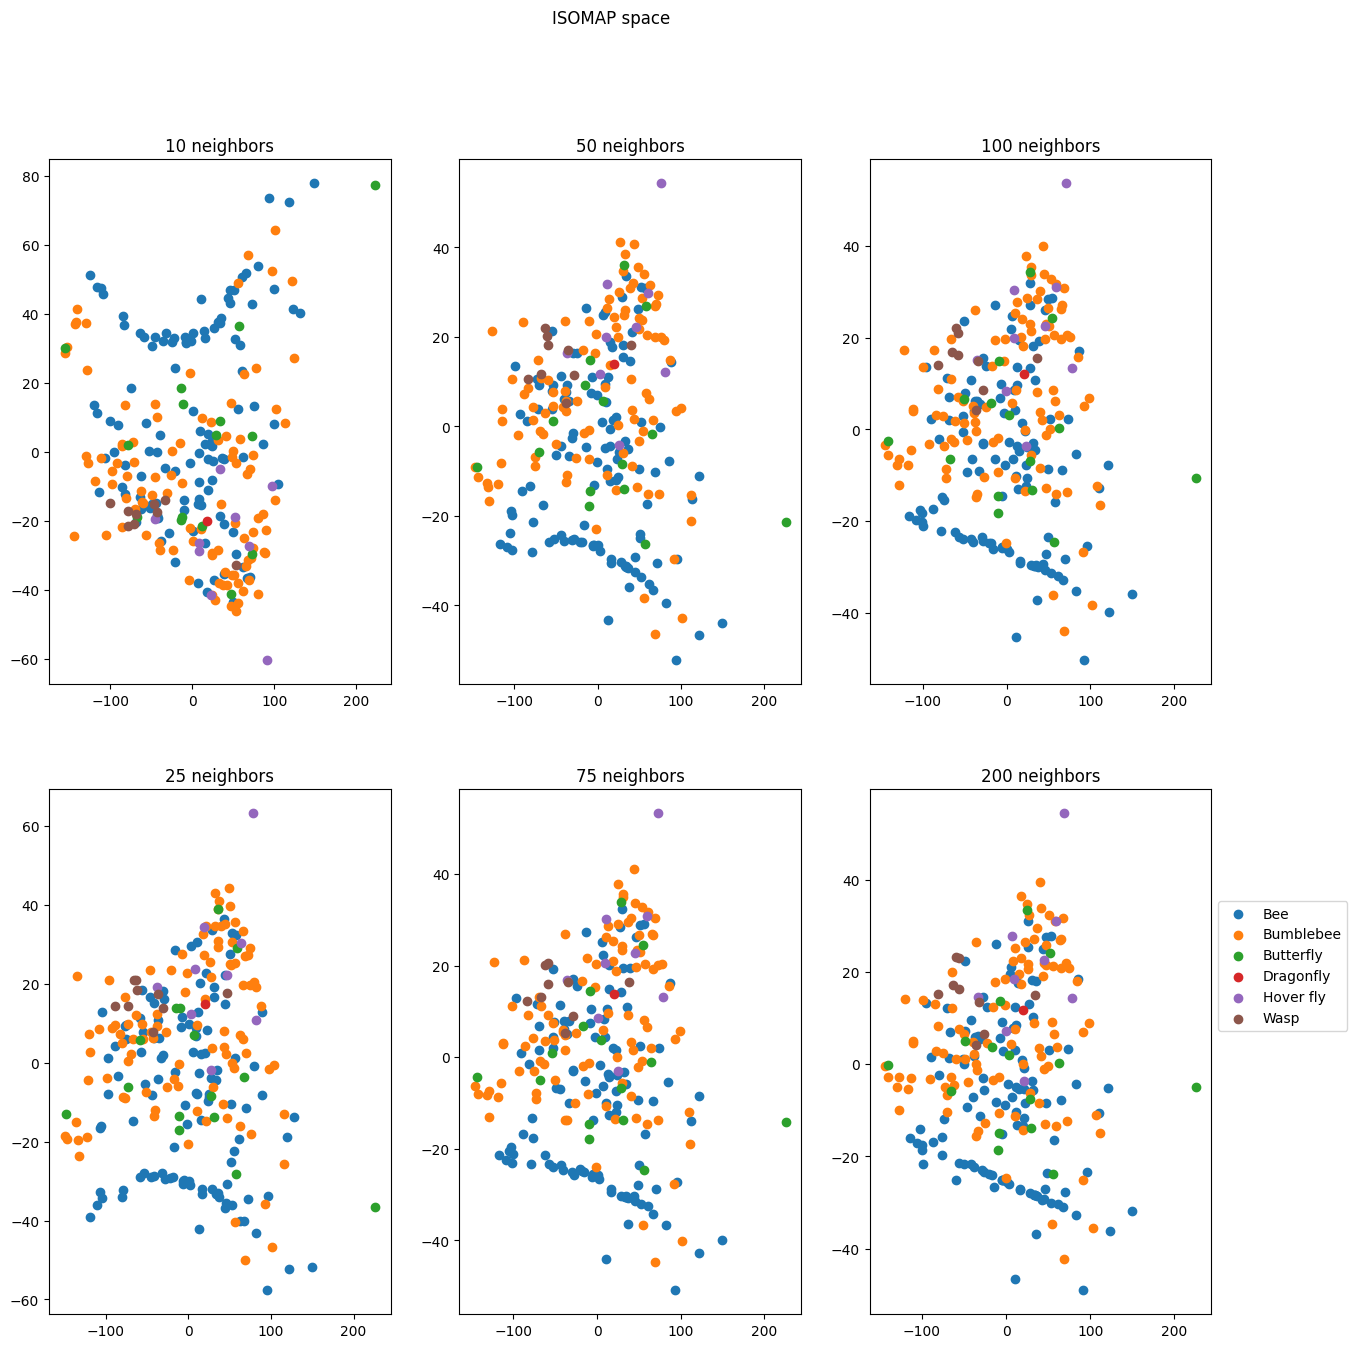

In [29]:
nb_lines = 2
nb_cols = 3

fig, ax = plt.subplots(nb_lines, nb_cols, figsize=(15, 15))
line_ids, col_ids = np.meshgrid(range(0, nb_lines), 
                                range(0, nb_cols))
fig.suptitle('ISOMAP space', fontsize=12)
for n_neighbor, line_id, col_id in zip([10, 25, 50, 75, 100, 200],
                                      line_ids.flatten(), col_ids.flatten()):
   model = Isomap(n_neighbors=n_neighbor)
   digits_lle = model.fit_transform(features)
   for dig in dig_list:
         ax[line_id, col_id].scatter(digits_lle[digit_class==dig, 0], digits_lle[digit_class==dig, 1],label=dig);    
   
   ax[line_id, col_id].set_title("{0} neighbors".format(n_neighbor))
plt.legend(bbox_to_anchor=(1, 0.8));

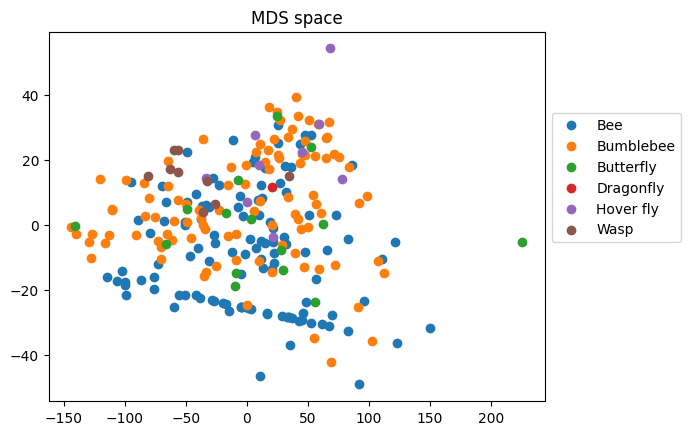

In [30]:
mds = MDS(random_state=0)
digits_mds = model.fit_transform(features)

fig, ax = plt.subplots();
for dig in dig_list:
     ax.scatter(digits_lle[digit_class==dig, 0], digits_lle[digit_class==dig, 1],label=dig); 
ax.legend(bbox_to_anchor=(1, 0.8));    
ax.set_title('MDS space', fontsize=12);            
